In [1]:
import geopandas as gpd
import pandas as pd
import pyvista as pv
import pyvistaqt as pyqt
import gemgis as gg
from sklearn.ensemble import RandomForestClassifier
import verde as vd
import numpy as np
from pyproj import CRS, Transformer
import plotly.express as px
import os                                                 # to set current working directory 
import matplotlib.pyplot as plt                           # plotting
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB
# import nbformat
import seaborn as sns
cmap = plt.cm.gist_earth_r
cmap2 = plt.cm.RdBu_r


import warnings
warnings.filterwarnings('ignore')

/Users/lorenzoperozzi/Documents/LAVORO/PYTHON_DEVELOPMENT/SITG_map/.venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


This is a tutorial for **Simple Kriging and Sequential Gaussian Simulation (SGSIM)** in Python with the GeostatsPy package (Pyrcz et al., 2021), GSLIB's KB2D and SGSIM programs translated to Python from the original FORTRAN GSLIB: Geostatistical Library methods (Deutsch and Journel, 1997).
This notebook is inspired form the excellent tutorials of Michael Pyrcz, Associate Professor, University of Texas at Austin, available [here](https://github.com/GeostatsGuy/PythonNumericalDemos).

In [2]:
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill):     # plot the variogram
    # index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=200,xlag=50,azm=azi,vario=vmodel);
    # index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=200,xlag=50,azm=azi+90.0,vario=vmodel);

    nlag = 200; xlag = 50; azm = 67.5;                                # project the model in the 045 azimuth
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag,xlag,azm,vario)                                          # project the model in the 135 azimuth
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag,xlag,azm+90,vario)
    
    plt.scatter(lags,gamma_maj,color = 'black',s = 15,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = 15,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,50*100],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,50*100]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    plt.grid(True)

def local_expectation(realizations):                      # calculate the local expectation / average realization
    cond_exp = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            cond_exp[iy,ix] = np.average(a = realizations[iy,ix,:])  
    return cond_exp

def local_standard_deviation(realizations):               # calculate the local standard deviation of realizations
    local_stdev = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            local_stdev[iy,ix] = np.std(a = realizations[iy,ix,:])  
    return local_stdev
 
def local_percentile(realizations,p_value):               # calculate the local percentile of realizations
    percentile = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            percentile[iy,ix] = np.percentile(a = realizations[iy,ix,:], q = p_value)  
    return percentile

def local_probability_exceedance(realizations,threshold): # calculate the local probability of exceeding a threshold 
    prob_exceed = np.zeros((ny,nx))
    for iy in range(0,ny): 
        for ix in range(0,nx): 
            prob_exceed[iy,ix] = np.sum(realizations[iy,ix,:] >= threshold)/realizations[0,0,:].size 
    return prob_exceed

The data set is part of the public dataset of GESDEC (Canton of Geneva) available at https://ge.ch/sitg/fiche/4108

In [3]:
df = pd.read_csv('../data/sondage_clean.csv')
df.describe()

,E,N,MOLASSE,PROFONDEUR,ALTITUDE,lat,lon
count,63.00,63.00,63.00,63.00,63.00,63.00,63.00
mean,2498157.31,1119250.34,-367.32,-111.58,417.63,46.22,6.12
std,1524.51,1724.57,37.88,92.05,24.36,0.02,0.02
min,2495176.14,1116172.65,-445.21,-300.00,370.14,46.19,6.08
25%,2496777.96,1117966.12,-387.50,-170.00,402.39,46.21,6.10
50%,2498580.01,1118962.50,-358.71,-70.70,418.07,46.21,6.12
75%,2499180.70,1120855.60,-348.60,-36.75,433.43,46.23,6.13
max,2500782.52,1121951.61,-286.00,-9.10,464.95,46.24,6.15


The area of interest consist of 63 wells in which the depth of the [Molasse](https://app2.ge.ch/tergeoportal/apps/MapJournal/index.html?appid=bf3be92de435483883f597f8aaca5285#) unit has been measured.

In [4]:
fig = px.scatter_mapbox(df, lat="lat", lon="lon", color="MOLASSE", size="ALTITUDE",
                  color_continuous_scale='earth', size_max=10, zoom=11,)

fig.update_layout(margin=dict(l=75, r=20, t=10, b=20),
mapbox = dict(style = "https://api.maptiler.com/maps/ch-swisstopo-lbm-grey/style.json?key=Y0QFvc1p5eTvlCMj4GEX",zoom= 11.8,center= {"lon": 6.115, "lat": 46.215},),)
fig.show()

### Data analytics and visualization
Take a lok at the available data:
- histogram 
- variogram

First, set limits for plotting

In [5]:
xmin = df.E.min(); xmax = df.E.max()         # range of x values
ymin = df.N.min(); ymax = df.N.max()               # range of y values
# no trimming 
tmin = -9999.; tmax = 9999. 
xsiz = 50; ysiz = 50                    # cell size
nx = 121; ny = 121                      # number of cells

# grid origin, location center of lower left cell
xmn = 2495000; ymn = 1116000    
molmin= -440; molmax = -280; 
molmean= -367; molvar=37.88**2

 x,y,z offsets = 46.19397659980645,19.13417168043954
 x,y,z offsets = 19.13417176335295,-46.193976565462584
 x,y,z offsets = 46.19397659980645,19.13417168043954
 x,y,z offsets = 19.13417176335295,-46.193976565462584


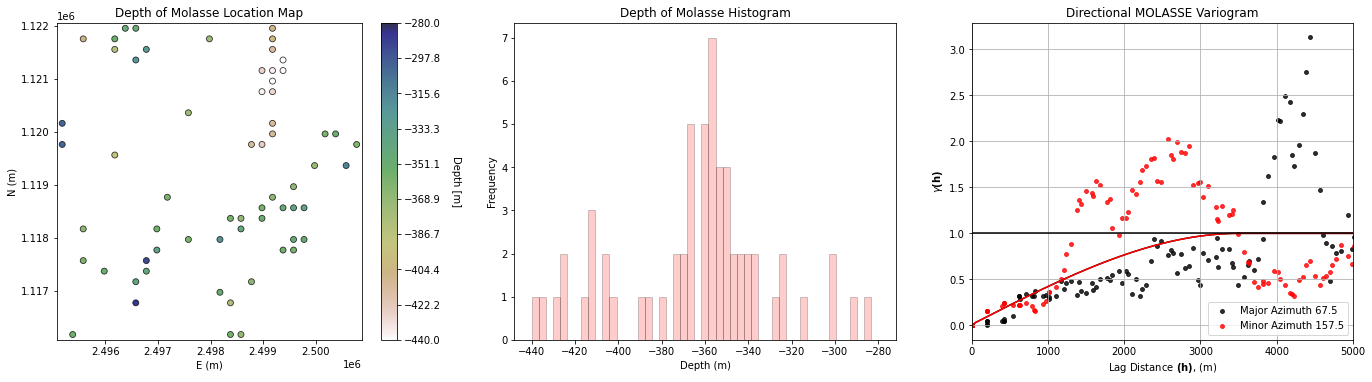

In [6]:
plt.subplot(131)
GSLIB.locmap_st(df,'E','N','MOLASSE',xmin-100,xmax+100,ymin-100,ymax+100,molmin,molmax,'Depth of Molasse Location Map','E (m)','N (m)','Depth [m]',cmap=cmap)

plt.subplot(132)
plt.hist(df['MOLASSE'].values,bins=np.linspace(molmin,molmax,50),color='red',alpha=0.2,edgecolor='black')
plt.xlabel('Depth (m)'); plt.ylabel('Frequency'); plt.title('Depth of Molasse Histogram')


df['NMol'], tvPor, tnsPor = geostats.nscore(df,'MOLASSE') 
lags, gamma_maj, npps_maj = geostats.gamv(df,'E','N','MOLASSE',tmin,tmax,xlag=50,xltol=100,nlag=200,azm=67.5,atol=22.5,bandwh=9999.9,isill=1);
lags, gamma_min, npps_min = geostats.gamv(df,'E','N','MOLASSE',tmin,tmax,xlag=50,xltol=100,nlag=200,azm=157.5,atol=22.5,bandwh=9999.9,isill=1);

nug = 0.01; nst = 1                                             # 2 nest structure variogram model parameters
it1 = 1; cc1 = 0.99; azi1 = 67.5; hmaj1 = 3500; hmin1 = 3500

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1)

nlag = 200; xlag = 50; azm = 67.5;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario)
azm = 157.5                                                     # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario)

plt.subplot(133)
vargplot('MOLASSE',lags,gamma_maj,gamma_min,npps_maj,npps_min,vario,azi=67.5,atol=22.5,sill=1)     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

In [7]:
nxdis = 1; nydis = 1
ndmin = 0; ndmax = 12; radius = 4000; ktype = 0; skmean = -367

### Simple Kriging

Let's make a simple kriging, estimation map and calculate the same statistics again to check the reproduction.


  Estimated   14641 blocks 
      average   -363.9567398929396  variance  716.1763756997534
 x,y,z offsets = 46.19397659980645,19.13417168043954
 x,y,z offsets = 19.13417176335295,-46.193976565462584


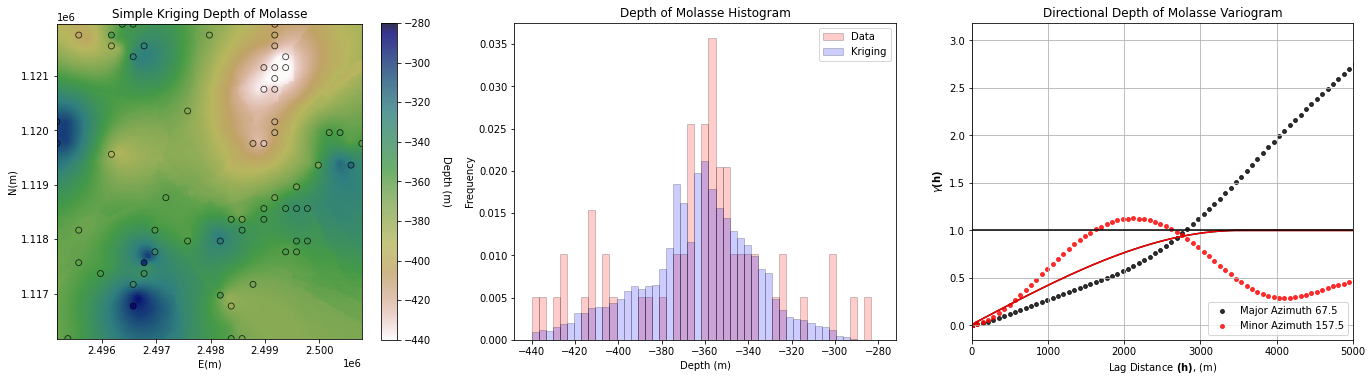

In [8]:
mol_kmap, mol_vmap = geostats.kb2d(df,'E','N','MOLASSE',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius=radius,ktype=ktype,skmean=molmean,vario=vario)

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(mol_kmap,xmin,xmax,ymin,ymax,xsiz,molmin,molmax,df,'E','N','MOLASSE','Simple Kriging Depth of Molasse','E(m)','N(m)','Depth (m)',cmap)

plt.subplot(132)
plt.hist(df['MOLASSE'].values,density=True,bins=np.linspace(molmin,molmax,50),color='red',alpha=0.2,edgecolor='black',label='Data')
plt.hist(mol_kmap.flatten(),density=True,bins=np.linspace(molmin,molmax,50),color='blue',alpha=0.2,edgecolor='black',label='Kriging')
plt.xlabel('Depth (m)'); plt.ylabel('Frequency'); plt.title('Depth of Molasse Histogram'); plt.legend(loc='upper right')

lags, sk_gamma_maj, npps_maj = geostats.gam(mol_kmap,tmin,tmax,xsiz,ysiz,ixd=1,iyd=-1,nlag=200,isill=1);
lags, sk_gamma_min, npps_min = geostats.gam(mol_kmap,tmin,tmax,xsiz,ysiz,ixd=1,iyd=1,nlag=200,isill=1);

plt.subplot(133)
vargplot('Depth of Molasse',lags,sk_gamma_maj,sk_gamma_min,npps_maj,npps_min,vario,azi=67.5,atol=22.5,sill=1)     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()


### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results. We will start with a test, comparision of simulation with simple and ordinary kriging.


0

 Data for SGSIM: Number of acceptable data     = 63
                 Number trimmed                = 0
                 Weighted Average              = -367.3176
                 Weighted Variance             = 1412.2993
                 Weighted Transformed Average  = 0.0023
                 Weighted Transformed Variance = 0.981
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
Reassigning data to nodes

 Realization 0: number   = 14641
                                   mean     = 0.0574 (close to 0.0?)
                                   variance = 0.6811 (close to gammabar(V,V)? approx. 1.0)
1

 Data for SGSIM: Number of acceptable data     = 63
                 Number trimmed                = 0
                 Weighted Average              = -367.3176
                 Weighted Variance             = 1412.2993
                 Weighted Transformed Average  = 0.0023
                 Weighted Transformed Variance = 0.981
S

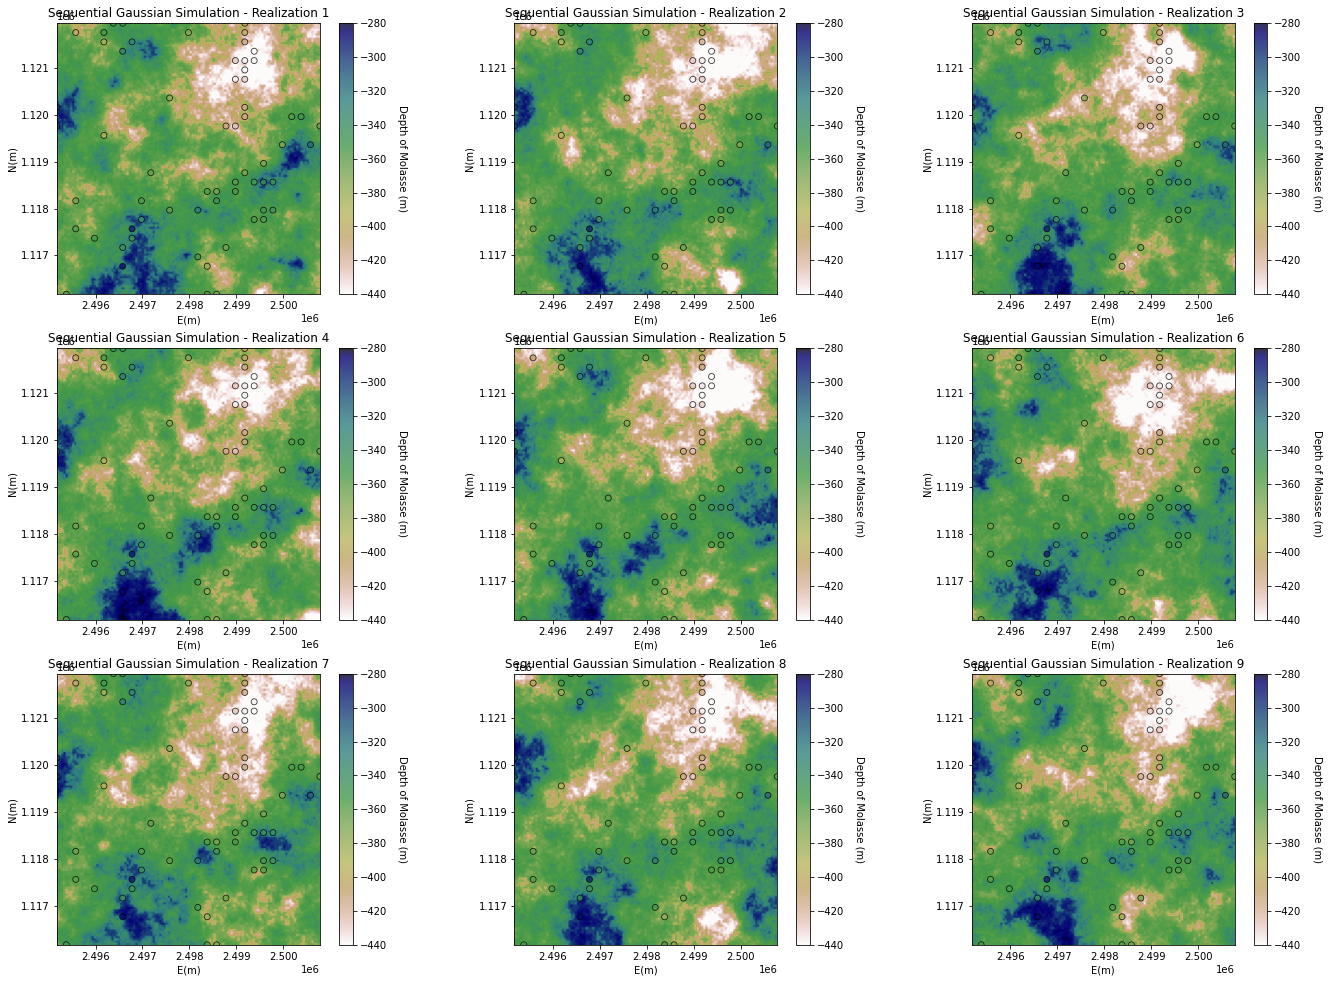

In [9]:
nreal = 10                        # number of bootstrap real                            
realizations = np.zeros((ny,nx,nreal))

for ireal in range(0,nreal):
    print(ireal)
    realizations[:,:,ireal] = geostats.sgsim(df,'E','N','MOLASSE',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=molmin,zmax=molmax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073 + ireal,
            ndmin=ndmin,ndmax=ndmax,nodmax=12,mults=0,nmult=2,noct=-1,radius=radius,radius1=2000,sang1=1,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)

for ireal in range(0,min(nreal,9)):
    plt.subplot(3,3,ireal+1)
    GSLIB.locpix_st(realizations[:,:,ireal],xmin,xmax,ymin,ymax,xsiz,molmin,molmax,df,'E','N','MOLASSE','Sequential Gaussian Simulation - Realization ' + str(ireal+1),'E(m)','N(m)','Depth of Molasse (m)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.2, wspace=0.2, hspace=0.2)
plt.show()

### Summarizing Local Uncertainty with the POSTSIM Method

Let's run the POSTSIM algorithm. It simply loops over all the locations ix and iy and calculates local summary statistics to quantify the local uncertainty.

We will start with the e-type and the conditional variance.

- e-type is the local expectation (just the average of the  realizations at each pixel as we assume all realizations are equally likely).
- conditional variance is the local variance 

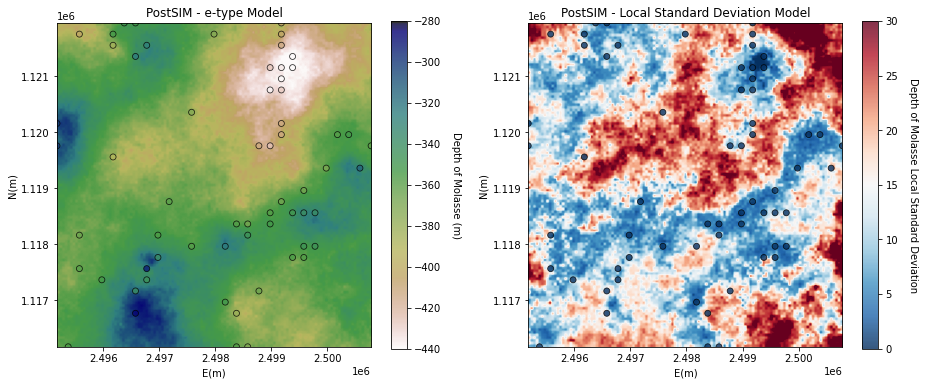

In [10]:
e_type = local_expectation(realizations)
local_stdev = local_standard_deviation(realizations)

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,molmin,molmax,df,'E','N','MOLASSE','PostSIM - e-type Model','E(m)','N(m)','Depth of Molasse (m)',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(local_stdev,xmin,xmax,ymin,ymax,xsiz,0.0,30,df,'E','N','MOLASSE','PostSIM - Local Standard Deviation Model','E(m)','N(m)','Depth of Molasse Local Standard Deviation',cmap2)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()




The e-type model is very simlar to a kriging model, except for:

- the Gaussian forward and back transform may change the results
- result are noisy due to too few realizations

The conditional variance is lowest at the data locations and increased away from the data

- the result is noisy due to too few realizations

### Local Percentiles

Now let's look at the:

- local percentile maps are the maps with the local percentile values sampled from the local realizations

We can interprete them as follows, at a location if we have a local P10 of -300 m, then we have a 90% probability of the depth is closeer to the surface.h.

Local percentiles are very convenient to understand local uncertainty. We must make sure that we do not mix them up with a percentile model (the model that is globally ranked as a specific percentile outcome.

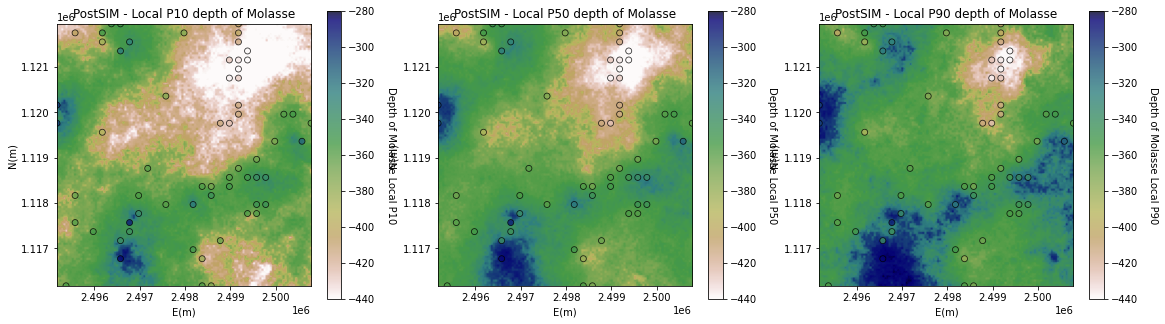

In [11]:
localp10 = local_percentile(realizations = realizations,p_value = 10)

localp50 = local_percentile(realizations = realizations,p_value = 50)

localp90 = local_percentile(realizations = realizations,p_value = 90)

plt.subplot(1,3,1)
GSLIB.locpix_st(localp10,xmin,xmax,ymin,ymax,xsiz,molmin,molmax,df,'E','N','MOLASSE','PostSIM - Local P10 depth of Molasse','E(m)','N(m)','Depth of Molasse Local P10',cmap)

plt.subplot(1,3,2)
GSLIB.locpix_st(localp50,xmin,xmax,ymin,ymax,xsiz,molmin,molmax,df,'E','N','MOLASSE','PostSIM - Local P50 depth of Molasse','E(m)','N(m)','Depth of Molasse Local P50',cmap)

plt.subplot(1,3,3)
GSLIB.locpix_st(localp90,xmin,xmax,ymin,ymax,xsiz,molmin,molmax,df,'E','N','MOLASSE','PostSIM - Local P90 depth of Molasse','E(m)','N(m)','Depth of Molasse Local P90',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1., wspace=0.2, hspace=0.2)
plt.show()

### VTK/pyvista visualization

In [12]:
grid_E = np.load('../data/grid_E.npy')
grid_N = np.load('../data/grid_N.npy')

mesh = pv.StructuredGrid()
mesh.points = np.array([grid_E.ravel(), grid_N.ravel(), localp90.ravel()]).T
mesh.dimensions =  [localp90.shape[1], localp90.shape[0], 1]
mesh["Elevation"] = np.flipud(localp90).ravel()
mesh_warped = mesh.warp_by_scalar(factor=5) # vertical exageration

import pyvistaqt as pvqt
p = pvqt.BackgroundPlotter()

p.add_mesh(mesh_warped, cmap='gist_earth_r',show_edges=False)
p.show_bounds(grid=True, location='front')
p.show_grid()
# mesh_warped.save('../data/GaussianProcess.vtk')

<vtkmodules.vtkRenderingAnnotation.vtkCubeAxesActor(0x7ff6122e5800) at 0x1406628e0>